# Importing Libraries and Images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

In [2]:
os.listdir("D:/Garbage_Classification/")

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

## Creating a DataFrame

In [3]:
data = pd.DataFrame()
path="D:/Garbage_Classification/"
for category in os.listdir(path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['target'] = category
    i = 0
    for photo in os.listdir(path+category):
        temp.loc[i, 'path'] = path+category+ "/" + photo
        temp.loc[i, 'filename'] = category+ "/" + photo
        temp.loc[i, 'target'] = category
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp

In [4]:
data

,path,target,filename
0,D:/Garbage_Classification/battery/battery1.jpg,battery,battery/battery1.jpg
1,D:/Garbage_Classification/battery/battery10.jpg,battery,battery/battery10.jpg
2,D:/Garbage_Classification/battery/battery100.jpg,battery,battery/battery100.jpg
3,D:/Garbage_Classification/battery/battery101.jpg,battery,battery/battery101.jpg
4,D:/Garbage_Classification/battery/battery102.jpg,battery,battery/battery102.jpg
...,...,...,...
15510,D:/Garbage_Classification/white-glass/white-gl...,white-glass,white-glass/white-glass95.jpg
15511,D:/Garbage_Classification/white-glass/white-gl...,white-glass,white-glass/white-glass96.jpg
15512,D:/Garbage_Classification/white-glass/white-gl...,white-glass,white-glass/white-glass97.jpg
15513,D:/Garbage_Classification/white-glass/white-gl...,white-glass,white-glass/white-glass98.jpg


### Displaying random images

D:/Garbage_Classification/biological/biological568.jpg


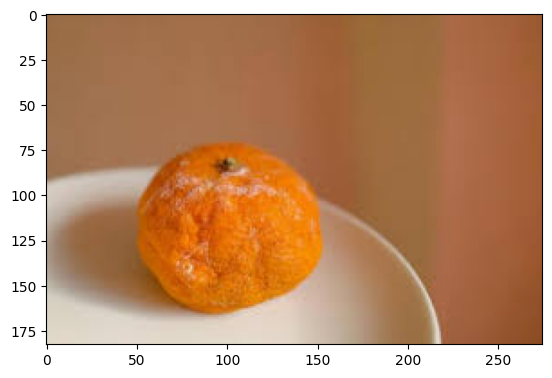

D:/Garbage_Classification/clothes/clothes4469.jpg


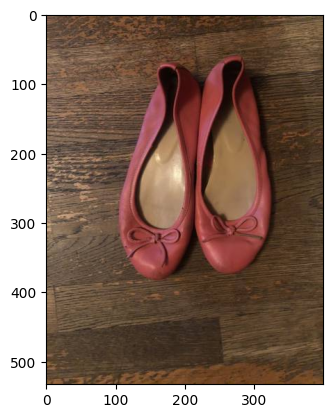

D:/Garbage_Classification/battery/battery302.jpg


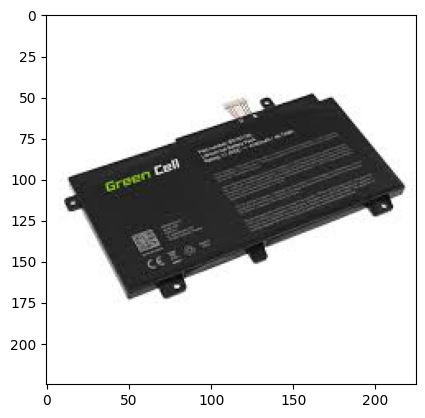

D:/Garbage_Classification/trash/trash354.jpg


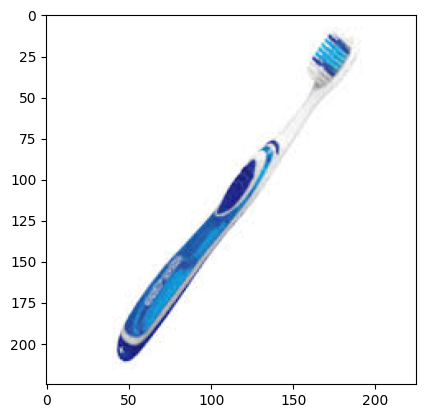

D:/Garbage_Classification/clothes/clothes719.jpg


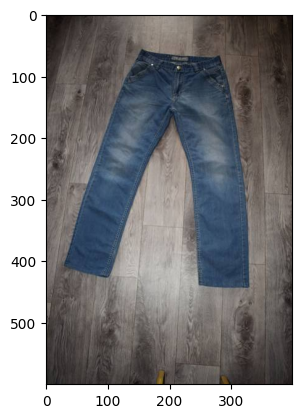

D:/Garbage_Classification/clothes/clothes1335.jpg


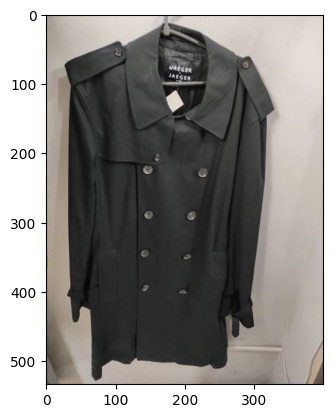

D:/Garbage_Classification/shoes/shoes377.jpg


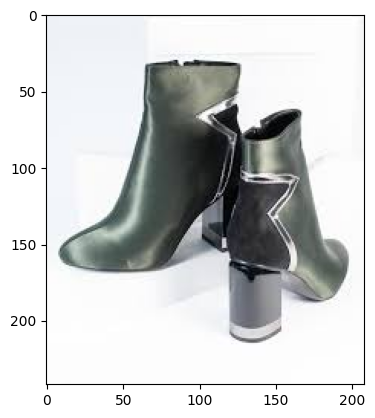

D:/Garbage_Classification/shoes/shoes692.jpg


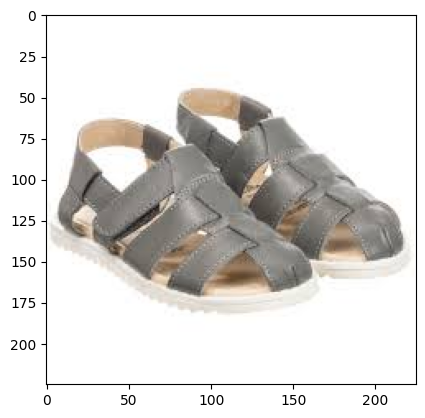

D:/Garbage_Classification/green-glass/green-glass518.jpg


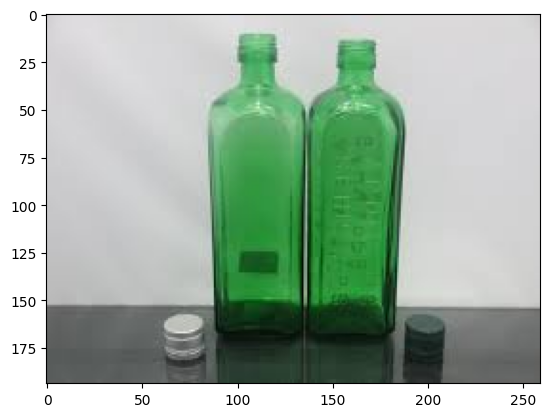

D:/Garbage_Classification/clothes/clothes2016.jpg


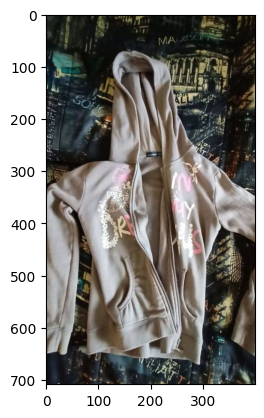

In [5]:
import random
import matplotlib.image as mpimg

for i in range (10):
    random_row = random.randint(0, len(data)-1)
    sample = data.iloc[random_row]
    image = mpimg.imread(sample['path'])
    plt.imshow(image)
    print(sample['path'])
    plt.show()

### Preprocessing the dataset

In [6]:
total_counts = 0

for category in os.listdir(path):
    count_class = 0
    for photo in os.listdir(path + category):
        count_class += 1
        total_counts += 1
    print(str(category) + " has " + str(count_class) + " photos")

battery has 945 photos
biological has 985 photos
brown-glass has 607 photos
cardboard has 891 photos
clothes has 5325 photos
green-glass has 629 photos
metal has 769 photos
paper has 1050 photos
plastic has 865 photos
shoes has 1977 photos
trash has 697 photos
white-glass has 775 photos


The dataset is **imbalanced**. We will remove some random images from 'clothes' and 'shoes' to improve the distribution.

In [7]:
clothesDrop=data[data['target']=='clothes'].sample(n=4525)
shoesDrop=data[data['target']=='shoes'].sample(n=1000)

In [8]:
data.drop(labels=clothesDrop.index.values, inplace=True)
data.drop(labels=shoesDrop.index.values, inplace=True)
data['target'].value_counts()

target
paper          1050
biological      985
shoes           977
battery         945
cardboard       891
plastic         865
clothes         800
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64

# Model

In [9]:
# Shape of EfficientNetB0
im_shape = (224, 224)
batch_size = 64
seed = 42

### Image Augmentation

**Image augmentation** is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. These image augmentation techniques not only expand the size of your dataset but also incorporate a level of variation in the dataset which allows your model to generalize better on unseen data. Keras **ImageDataGenerator** class provides a quick and easy way to augment the images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. It is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage. ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

Splitting the dataset into training, testing and validation.

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(7992, 999, 999)

Using ImageDataGenerator on training, testing and validation dataset.

In [12]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 7992 validated image filenames belonging to 12 classes.


In [13]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 999 validated image filenames belonging to 12 classes.


In [14]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 999 validated image filenames belonging to 12 classes.


In [15]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### EfficientNetB0

**Transfer Learning** is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task. To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task. By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.

**EfficientNet-B0** is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
'''
Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
We flatten the output of the convolutional layers to create a single long feature vector. 
And it is connected to the final classification model, which is called a fully-connected layer.
'''
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
'''
Optimizers are Classes or methods used to change the attributes of the model such as weights and learning rate 
in order to reduce the losses. Optimizers help to get results faster.
'''
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

epochs = 30

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
124/124 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9928
Epoch 1: val_loss improved from inf to 0.50180, saving model to model_EfficientnetB0.h5


c:\Python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 168s 1s/step - loss: 0.0297 - accuracy: 0.9928 - val_loss: 0.5018 - val_accuracy: 0.9198
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9941
Epoch 2: val_loss did not improve from 0.50180
124/124 [==============================] - 167s 1s/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.5759 - val_accuracy: 0.9146
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9931
Epoch 3: val_loss did not improve from 0.50180
124/124 [==============================] - 166s 1s/step - loss: 0.0284 - accuracy: 0.9931 - val_loss: 0.6089 - val_accuracy: 0.9240
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9951
Epoch 4: val_loss did not improve from 0.50180
124/124 [==============================] - 168s 1s/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.6628 - val_accuracy: 0.9271
Epoch 5/30
124/124 [=======================

# Prediction and Accuracy

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

999/999 [==============================] - 39s 37ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.96      0.99      0.97        95
  biological       0.97      1.00      0.99       109
 brown-glass       0.93      0.93      0.93        59
   cardboard       0.92      0.93      0.93        90
     clothes       0.97      0.97      0.97        73
 green-glass       0.93      0.92      0.92        72
       metal       0.83      0.84      0.84        70
       paper       0.89      0.91      0.90       102
     plastic       0.84      0.88      0.86        89
       shoes       1.00      0.95      0.97        96
       trash       0.95      0.91      0.93        69
 white-glass       0.89      0.83      0.86        75

    accuracy                           0.93       999
   macro avg       0.92      0.92      0.92       999
weighted avg       0.93      0.93      0.93       999



**Precision** is one indicator of a machine learning model's performance – the quality of a positive prediction made by the model. 
The **recall** is the measure of our model correctly identifying True Positives.
**F1 Score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 


In [19]:
cm

array([[ 94,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 109,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  55,   0,   0,   2,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,  84,   0,   0,   0,   6,   0,   0,   0,   0],
       [  0,   0,   0,   0,  71,   0,   1,   0,   0,   0,   1,   0],
       [  0,   1,   0,   0,   0,  66,   2,   0,   2,   0,   0,   1],
       [  2,   0,   2,   0,   0,   1,  59,   0,   2,   0,   1,   3],
       [  0,   1,   0,   5,   0,   0,   1,  93,   2,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   2,   4,  78,   0,   1,   3],
       [  0,   1,   1,   0,   1,   0,   1,   0,   0,  91,   0,   1],
       [  1,   0,   1,   2,   0,   1,   0,   1,   0,   0,  63,   0],
       [  1,   0,   0,   0,   0,   1,   2,   0,   9,   0,   0,  62]],
      dtype=int64)